In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import os

home = '/content/drive/MyDrive/2ReadyForFineTuning/WebQA/'

imroot = home+'WebQA_NewImages'
os.chdir(home)

In [ ]:
prefix = 'webqa'

In [ ]:
import json
import ast
datalen = 0
dumpdict = { "info": {}, "task_type": "Open-Ended", "data_type": "webqa", "license": {}, "data_subtype": prefix, "questions": [] }

with open(home+prefix+'.json') as f:
  data = json.load(f)
  print(len(data))
  global datalen
  datalen = len(data)
  print(datalen)
  for i in data[0:int(datalen*0.8)]:
    imlist = i['images']
    anslist = [str(i) for i in i['answer_choices']]
    try:
      assert len(anslist) == 2
    except:
      print(i)
    dumpdict['questions'].append( { "image_id": imroot+"/"+imlist.lstrip('./images/'), "question": i['question']+" "+i['passage'], "question_id": i['qid'], "answer_choices": anslist, "answer_id": int(i['answer']) } )

with open('/content/'+prefix+'_train.jsonl','w+') as w:
  w.write(json.dumps(dumpdict,indent=4))

#print(dumpdict)

9438
9438


In [ ]:
import json
f = open('/content/'+prefix+'_train.jsonl','r')
data_questions = json.load(f)
questions = data_questions['questions']

print(data_questions.keys())
print("Number of questions:", len(questions))

dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])
Number of questions: 7550


In [ ]:
questions[0]

{'image_id': '/content/drive/MyDrive/2ReadyForFineTuning/WebQA/WebQA_NewImages/d5bbc6d80dba11ecb1e81171463288e9.png',
 'question': '"Are both the National Museum of the American Indian in Washington, D.C. and the Xanadu House in Kissimmee, Florida the same color?" Left: National Museum of the American Indian in Washington, D.C\nRight: Xanadu-House-in-Kissimmee-Florida-1985 A photo of the Xanadu House that was located in Kissimmee, Florida, showing the exterior of the house.',
 'question_id': 'd5bbc6d80dba11ecb1e81171463288e9',
 'answer_choices': ['"No, the National Museum of the American Indian in Washington, D.C. is beige and the Xanadu House in Kissimmee, Florida is white."',
  '"Yes, both the National Museum of the American Indian in Washington, D.C. and the Xanadu House in Kissimmee, Florida are beige."'],
 'answer_id': 1}

In [ ]:
from os import listdir
from os.path import isfile, join

file_names = [f for f in listdir(imroot) if isfile(join(imroot, f))]
print(file_names)
print(len(file_names))

['d5cd7c5c0dba11ecb1e81171463288e9.png', 'd5cd7c840dba11ecb1e81171463288e9.png', 'd5cd7d1a0dba11ecb1e81171463288e9.png', 'd5cd7d6a0dba11ecb1e81171463288e9.png', 'd5cd7dd80dba11ecb1e81171463288e9.png', 'd5cd7d920dba11ecb1e81171463288e9.png', 'd5cd7e280dba11ecb1e81171463288e9.png', 'd5cd7ea00dba11ecb1e81171463288e9.png', 'd5cd7ec80dba11ecb1e81171463288e9.png', 'd5cd7f540dba11ecb1e81171463288e9.png', 'd5cd80440dba11ecb1e81171463288e9.png', 'd5cd808a0dba11ecb1e81171463288e9.png', 'd5cd81480dba11ecb1e81171463288e9.png', 'd5cd81c00dba11ecb1e81171463288e9.png', 'd5cd81980dba11ecb1e81171463288e9.png', 'd5cd82380dba11ecb1e81171463288e9.png', 'd5cd82600dba11ecb1e81171463288e9.png', 'd5cd82a60dba11ecb1e81171463288e9.png', 'd5cd833c0dba11ecb1e81171463288e9.png', 'd5cd82ce0dba11ecb1e81171463288e9.png', 'd5cd84fe0dba11ecb1e81171463288e9.png', 'd5cd83640dba11ecb1e81171463288e9.png', 'd5cd85940dba11ecb1e81171463288e9.png', 'd5cd85e40dba11ecb1e81171463288e9.png', 'd5cd86a20dba11ecb1e81171463288e9.png',

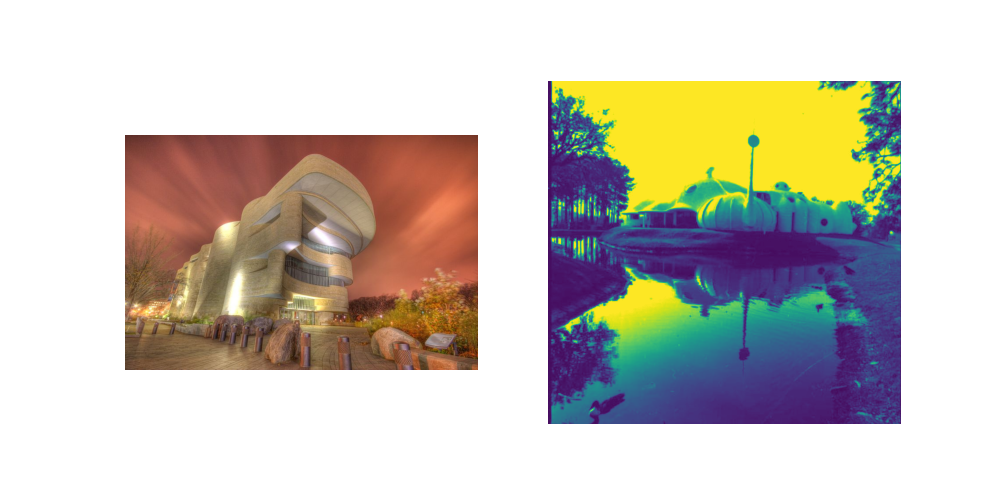

In [ ]:
from PIL import Image

path = questions[0]['image_id']
image = Image.open(path)
image

In [ ]:
from transformers import ViltConfig

config = ViltConfig.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import torch
from PIL import Image

class VQADataset(torch.utils.data.Dataset):

    def __init__(self, questions, processor):
        self.questions = questions
        self.processor = processor

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        questions = self.questions[idx]
        image = Image.open(questions['image_id']).convert("RGB")
        text = questions['question']
        encoding = self.processor(image, text, padding="max_length", truncation=True, return_tensors="pt")
        for k,v in encoding.items():
          encoding[k] = v.squeeze()
        targets = torch.zeros(len(questions['answer_choices']))
        targets[questions['answer_id']] = 1.0
        encoding["labels"] = targets
        return encoding

In [ ]:
from transformers import ViltProcessor

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1602: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
dataset = VQADataset(questions=questions,processor=processor)

In [ ]:
dataset[0]

{'input_ids': tensor([ 101, 1000, 2024, 2119, 1996, 2120, 2688, 1997, 1996, 2137, 2796, 1999,
        2899, 1010, 1040, 1012, 1039, 1012, 1998, 1996, 1060, 5162, 8566, 2160,
        1999, 3610, 5714, 4168, 2063, 1010, 3516, 1996, 2168, 3609, 1029, 1000,
        2187, 1024, 2120,  102]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'pixel_values': tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],

In [ ]:
dataset[1].keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])

In [ ]:
len(dataset)

7550

In [ ]:
processor.decode(dataset[0]['input_ids'])

'[CLS] " are both the national museum of the american indian in washington, d. c. and the xanadu house in kissimmee, florida the same color? " left : national [SEP]'

In [ ]:
labels = torch.nonzero(dataset[0]['labels']).squeeze().tolist()
labels

1

In [ ]:
from transformers import ViltForQuestionAnswering

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-mlm", num_labels=2)

model.to(device)

Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-mlm and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.1.bias', 'classifier.1.weight', 'classifier.3.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViltForQuestionAnswering(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=76

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  input_ids = [item['input_ids'] for item in batch]
  pixel_values = [item['pixel_values'] for item in batch]
  attention_mask = [item['attention_mask'] for item in batch]
  token_type_ids = [item['token_type_ids'] for item in batch]
  labels = [item['labels'] for item in batch]

  batch = {}
  batch['input_ids'] = torch.stack(input_ids)
  batch['attention_mask'] = torch.stack(attention_mask)
  batch['token_type_ids'] = torch.stack(token_type_ids)
  batch['pixel_values'] = torch.stack(pixel_values)
  batch['labels'] = torch.stack(labels)

  return batch

train_dataloader = DataLoader(dataset, collate_fn=collate_fn, batch_size=3, shuffle=True)

In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
for k,v in batch.items():
  print(k, v.shape)

input_ids torch.Size([3, 40])
attention_mask torch.Size([3, 40])
token_type_ids torch.Size([3, 40])
pixel_values torch.Size([3, 3, 320, 608])
labels torch.Size([3, 2])


## Start Training

In [ ]:
from tqdm.notebook import tqdm
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# -- CHANGE BASED ON HOW MANY EPOCHS YOU WANT TO RUN FOR
e = 5

model.train()
for epoch in range(e):
   print(f"Epoch: {epoch}")
   for batch in tqdm(train_dataloader):
        batch = {k:v.to(device) for k,v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        #print("Loss:", loss.item())
        loss.backward()
        optimizer.step()

Epoch: 0


  0%|          | 0/2517 [00:00<?, ?it/s]

Epoch: 1


  0%|          | 0/2517 [00:00<?, ?it/s]

Epoch: 2


  0%|          | 0/2517 [00:00<?, ?it/s]

Epoch: 3


  0%|          | 0/2517 [00:00<?, ?it/s]

Epoch: 4


  0%|          | 0/2517 [00:00<?, ?it/s]

## Inference

In [ ]:
import json
import ast
datalen = 0
dumpdict = { "info": {}, "task_type": "Open-Ended", "data_type": "webqa", "license": {}, "data_subtype": prefix, "questions": [] }

with open(home+prefix+'.json') as f:
  data = json.load(f)
  print(len(data))
  global datalen
  datalen = len(data)
  print(datalen)
  for i in data[int(datalen*0.8):datalen]:
    test_imlist = i['images']
    test_anslist = [str(i) for i in i['answer_choices']]
    try:
      assert len(test_anslist) == 2
    except:
      print(i)
    dumpdict['questions'].append( { "image_id": imroot+"/"+test_imlist.lstrip('./images/'), "question": i['question']+" "+i['passage'], "question_id": i['qid'], "answer_choices": test_anslist, "answer_id": int(i['answer']) } )

with open('/content/'+prefix+'_test.jsonl','w+') as w:
  w.write(json.dumps(dumpdict,indent=4))

#print(dumpdict)

9438
9438


In [ ]:
import json
f = open('/content/'+prefix+'_test.jsonl','r')
test_data_questions = json.load(f)
test_questions = test_data_questions['questions']

print(test_data_questions.keys())
print("Number of questions:", len(test_questions))

dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])
Number of questions: 1888


In [ ]:
test_dataset = VQADataset(questions=test_questions,processor=processor)

In [ ]:
len(test_dataset)

1888

# Single Instance Inference

In [ ]:
exid = 1
example = test_dataset[exid]
print(example.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'pixel_values', 'pixel_mask', 'labels'])


In [ ]:
# add batch dimension + move to GPU
example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}

# forward pass
outputs = model(**example)

In [ ]:
logits = outputs.logits
predicted_class = logits.argmax(-1).item()
print("Predicted answer:", predicted_class)
print("Ground-truth answer:", test_dataset[exid]['labels'].argmax(-1).item())

Predicted answer: 0
Ground-truth answer: 1


# Batch Inference

In [ ]:
import csv
filprefix = prefix+"_result"

count = 0
st = 0
end = datalen-int(datalen*0.8)
with open(filprefix+'.csv', 'w+') as k:
  spamwriter = csv.writer(k)
  spamwriter.writerow(["qid","pred_ans","gt_ans","correctness"])
  for exid in range(st,end):
    correctness = 0
    example = test_dataset[exid]
    example = {k: v.unsqueeze(0).to(device) for k,v in example.items()}
    outputs = model(**example)
    logits = outputs.logits
    predicted_class = logits.argmax(-1).item()
    gtclass = test_dataset[exid]['labels'].argmax(-1).item()
    if gtclass==predicted_class:
      count+=1
      correctness = 1
    spamwriter.writerow([exid,predicted_class, gtclass,correctness])